## Business Understanding

Tanzania, as a developing country, struggles with providing clean water to its population of over 57,000,000. Waterpoints are an invaluable source of water for household needs such as drinking and washing. These are strategically situated to help rural communities and given their importance, need to be constantly available for the communities. There are many waterpoints already established in the country, however, some are in need of repair while others have failed altogether. 

The primary task of this notebook is to predict the condition of a water well, given detailed information about the pumps. Ultimately, we will create a machine learning model to accurately determine contributing factors that can preemptively determine pump repair and/or failure. Knowing and addressing the most important factors are upkept will ensure pumps continue to provide clean water to people in Tanzania.

This information will prove useful to the entity responsible for the upkeep and maintenance of such waterpoints, as well as external donors that may be funding the operational costs associated with the equipment.

## Data Understanding

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

# training_values.csv = features/dimensions we will be examining
# training_labels.csv = condition of the waterpoint 

training_values = pd.read_csv('training_values.csv')
training_labels = pd.read_csv('training_labels.csv')

In [2]:
# join the two dataframes on the id so we can match the correct condition to the correct waterpoint
df = training_values.set_index('id').join(training_labels.set_index('id'), how='inner')
df.reset_index(inplace=True)

In [3]:
display(df.head())
display(df.info())

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

None

> **Observations:** We will need to strategically reduce the current number of features, using domain knowledge and machine learning methods. Detailed information about what each feature means is defined in the `feature_descriptions.txt` data dictionary. We will examine the specific value counts for each column, shortly.

In [4]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


> **Observations:** `amount_tsh` (amount of water available to waterpoint) appears to have an outlier(s) as the _max_ values is significantly higher than the _mean_. We have no information on the interpretation of `num_private`, but has values from 0 to 1776, which is a signficant range. We also see 0 values for `construction_year`, which means we'll have to take that into consideration when dealing with missing/null values.

In [5]:
# obtain normalized value counts for each column
for col in df.columns:
    print(" ")
    print(f'---{col}---')
    print(df[col].value_counts())

 
---id---
2047     1
72310    1
49805    1
51852    1
62091    1
        ..
46396    1
36155    1
34106    1
38200    1
0        1
Name: id, Length: 59400, dtype: int64
 
---amount_tsh---
0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64
 
---date_recorded---
2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2011-09-19      1
2011-09-23      1
2011-09-05      1
2011-09-01      1
2011-09-25      1
Name: date_recorded, Length: 356, dtype: int64
 
---funder---
Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Oxfarm Gb                    1
Tlc/samora                   1
Cida                         1
John Skwe

> **Observations:** These results provide a great starting point in which features might be heavily correlated with one another or present similar data, like:
- `longitude`/`latitude` and `subvillage` and `region` and `region_code` and `district_code` and `lga/ward`
- `scheme_management` and `scheme_name`
- `extraction_type` and `extraction_type_group` and `extraction_type_class`
- `management` and `management_group`
- `water_quality` and `quality_group`
- `quantity` and `quantity_group`
- `source` and `source_type` and `source_class`
- `waterpoint_type` and `waterpoint_type_group`
- `payment` and `payment_type`

> These datapoints don't have any relevance or impact on the functionality of the wellpoint:
- `id`
- `wpt_name`
- `recorded_by` (same value for all datapoints)

> As we do not understand the feature description for `num_private` or `public_meeting` - it will be excluded from further analaysis.

> It also provides the three labels with which we will categorize the waterpoints:
- `functional`
- `non functional`
- `functional needs repair`

In [8]:
# examine dataset for NaN values
df.isna().sum()

# data.isna().any().any()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [9]:
# check original dataframe for duplicate values by unique `id` and `construction_year`
df[df.duplicated(['id','construction_year'])]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group


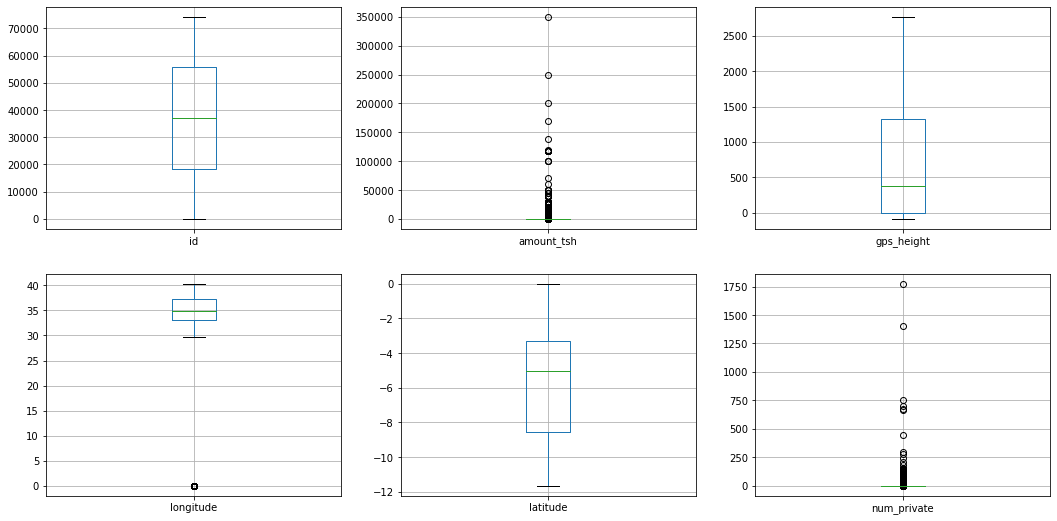

In [10]:
# create a boxplot to look for outliers (remove non-applicable columns)
cols = [col for col in df.columns if df[col].dtype != 'O']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,9))
for xcol, ax in zip(cols, axes.flatten()):
    boxplot = df.boxplot(column=xcol, ax=ax)

In [11]:
# examine outliers in further detail
display(df[df.amount_tsh >= 190000])
display(df[df.population >= 20000]) 

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
10812,41564,350000.0,2013-03-01,NaN,1558,NaN,34.840029,-4.542934,Mtinko Primary,0,...,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
22191,4128,250000.0,2011-03-04,Ded,285,WU,38.410852,-6.117538,Miono Dispensary,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
22817,7860,200000.0,2011-08-08,Government Of Tanzania,98,Government,38.978067,-5.122702,Shuleni,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
30537,12169,0.0,2011-03-12,Government Of Tanzania,184,DWE,38.783756,-5.181904,Mkwajuni,0,...,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


> **Observation**: None of the datapoints look like it was incorrectly entered and make reasonable sense. We'll include these outliers for now and determine at a later time, if removing them aids in model accuracy. Additionally, these waterpoints could be geographically positioned in a place with a large basin. Also populations tend to congregate, so it is not unreasonable to have outliers in available water at certain waterpoints or large populations.

## Visualizations

In [12]:
# set font and color scheme
plt.style.use('bmh')
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)

### Functionality of Pumps and Population Around Pumps

Functionality of the Wells


functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

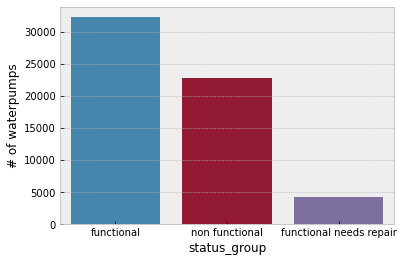

Population Around the Wells


status_group
functional                 6050282
functional needs repair     755916
non functional             3880455
Name: population, dtype: int64

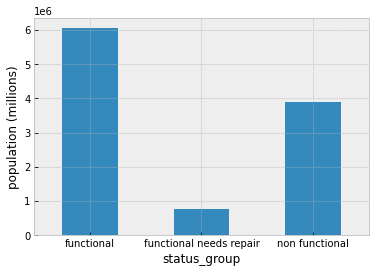

In [13]:
# show normalized count of different status groups
print("Functionality of the Wells")
display(df.status_group.value_counts(normalize=True))
ax = sns.countplot(df['status_group'])
ax.set(ylabel='# of waterpumps')
plt.show()

# show populations affected by each status_group
print("Population Around the Wells")
display(df.groupby(df['status_group'])['population'].sum())

f,ax1 = plt.subplots(figsize =(6,4))
pop_pump = df.groupby(df['status_group'])['population'].sum()
pop_pump.plot(x='status_group', y = 'population', kind='bar')
plt.xticks(rotation=0)
plt.xlabel('status_group')
plt.ylabel('population (millions)')
plt.show()

> **Observation**: Within our available data, over half **(54.3%)** of the waterpoints are functional, with **38.4%** being non-functional. <br><br> Additionally, there are **3,880,455** people that do not have access to a functional waterpoint. This is indication of a severe shortage of functionable water pumps.

### Average Amount of Water Per Status Group

Average amount of water per non-functional pump: 123.48


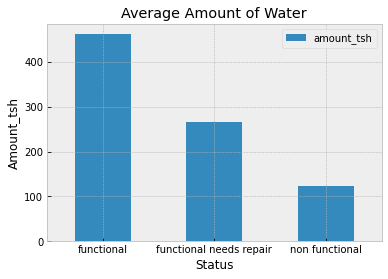

In [14]:
# group the data by the average amount of water per status_group
avg_water = df[['amount_tsh','status_group']].groupby(['status_group']).mean()

# average amount of water per non functional pump
nonfunc_avg_amt = df[df['status_group'] == 'non functional']['amount_tsh'].mean()
print('Average amount of water per non-functional pump: %.2f' % nonfunc_avg_amt)

# plot the grouping
f,ax1 = plt.subplots(figsize =(6,4))
avg_water.plot.bar(ax=ax1)
plt.xticks(rotation=0)
plt.xlabel('Status')
plt.ylabel('Amount_tsh')
plt.title('Average Amount of Water')
plt.show()

In [15]:
# average amount of water per pump when the quantity is dry
dry_avg_amt = df[df['quantity'] == 'dry']['amount_tsh'].mean()
print('Average amount of water per pump when quantity is dry: %.2f' % dry_avg_amt)

Average amount of water per pump when quantity is dry: 129.41


> **Observation**: The data intuitively makes sense - the non-functional pumps have less availabe water on average per pump and hence, may be why they are non-functional. In other words, some of these non-functional pumps may be dry and run out of available water.

### Functionality of Pumps by Funder

In [16]:
# examine the status_group of pumps grouped by the funder
pd.crosstab(df['funder'],df['status_group']).sort_values('non functional',ascending=False).style.background_gradient(cmap='summer_r')

> **Observation**: In the table above, the darker green colors represent the higher values in that column. The `Government of Tanzania` is by far the greatest funder by volume of pumps, but also has a significant number of their pumps being non-functional. `World Vision` has an interesting ratio of **753:372** of **functional:non-functional** pumps.

### Functionality of Pumps by Funder (Percentages)

In [42]:
# examine percentages of functional vs non-functional pumps by funder
list_of_funders = pd.DataFrame(pd.crosstab(df['funder'], df['status_group']))

# set minimum # of pumps funded to filter results for only experienced funders
threshold_number_of_pumps = 500
considerable_funders = list_of_funders[list_of_funders['functional'] + list_of_funders['functional needs repair'] + list_of_funders['non functional'] >= threshold_number_of_pumps]

# obtain percentages for each funder
percentages_funders = considerable_funders.apply(lambda r: r/r.sum()*100, axis=1)

# obtain ratio of functional vs non-functional pumps
percentages_funders['delta'] = percentages_funders['functional'] - percentages_funders['non functional']
funder_df = percentages_funders.sort_values('delta', ascending=False)

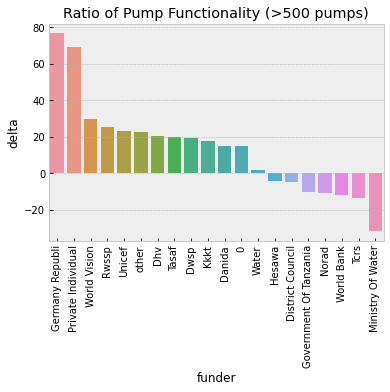

In [47]:
f,ax = plt.subplots(figsize =(6,4))
ax = sns.barplot(x=funder_df.index, y=funder_df.delta, data=funder_df)
plt.xticks(rotation=90)
plt.title('Ratio of Pump Functionality (>500 pumps)')
plt.show()

> **Observation**: The `Government of Tanzania` is the greatest funder, but we see a pretty poor delta of **-10.4** when it comes to functionality. Pumps funded by`Germany Republi` and `Private Individual` have significantly higher ratios of functionality than other funders who have funded over 500 pumps.

### Functionality of Pumps by Installer (Percentages)

status_group,functional,functional needs repair,non functional
installer,,,
DWE,54.206413,9.320768,36.472819
Government,29.315068,14.027397,56.657534
RWE,25.207297,11.359867,63.432836
Central government,27.009646,0.643087,72.347267
DANIDA,51.619048,7.904762,40.476190
KKKT,46.993318,6.904232,46.102450
TCRS,41.018388,5.940594,53.041018
Hesawa,56.547619,2.023810,41.428571
0,57.271557,0.386100,42.342342


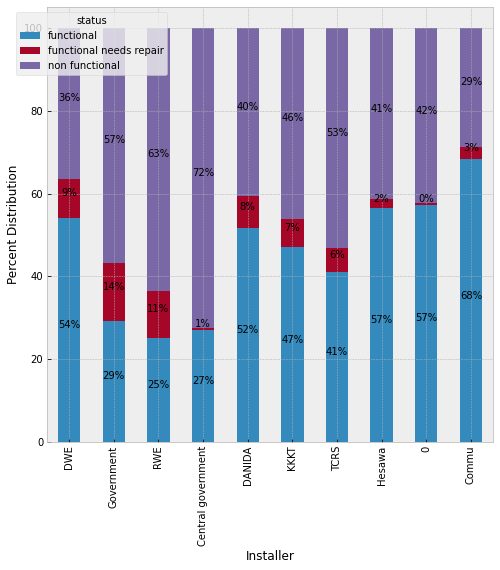

In [19]:
# examine the percent stacked bar graph of top 10 installers broken down by the status_group
ax = pd.crosstab(df['installer'], df['status_group']).sort_values('non functional',ascending=False).apply(lambda r: r/r.sum()*100, axis=1)[:10]
ax_1 = ax.plot.bar(figsize=(8,8),stacked=True, rot=0)
display(ax)

plt.legend(loc='upper center', bbox_to_anchor=(0.1, 1.0), title="status")
plt.xticks(rotation=90)
plt.xlabel('Installer')
plt.ylabel('Percent Distribution')

for rec in ax_1.patches:
    height = rec.get_height()
    ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')
plt.show()

> **Observation**: The top 10 installers (by # of water pumps installed) have a high non-functional percentage ranging from **29%** (Commu) to **72%** (Central Government).

### Functionality of Pumps by Extraction Type

status_group,functional,functional needs repair,non functional
extraction_type_group,,,
afridev,67.796610,2.372881,29.830508
nira/tanira,66.482708,7.861172,25.656120
rope pump,64.966741,3.769401,31.263858
india mark ii,60.333333,3.291667,36.375000
gravity,59.925317,10.085885,29.988798
swn 80,56.948229,5.776567,37.275204
submersible,53.876032,4.094514,42.029455
other handpump,47.252747,5.494505,47.252747
india mark iii,44.897959,1.020408,54.081633


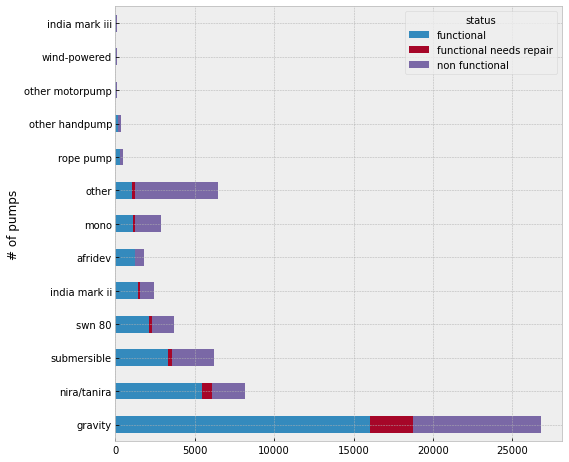

In [20]:
# examine the status_group and # of pumps grouped by the extraction_type_group
ct = pd.crosstab(df['extraction_type_group'],df['status_group'])
extraction_percentages = ct.apply(lambda r: r/r.sum()*100, axis=1).sort_values('functional',ascending=False)
display(extraction_percentages)

ct.sort_values('functional',ascending=False).plot.barh(figsize=(8,8), stacked=True)
plt.legend(title='status')
plt.ylabel('# of pumps')
plt.show()

> **Observation**: The majority of the pumps extract water via gravity methods. `afridev` and `nira/tanira` extraction methods have the highest functionality rate **67.8%** and **66.5%**, respectively), while `other` methods have the lowest functionality rate at **16.0%**.

## Data Preparation

In [21]:
# create function to reduce values in a column
def feature_reduction(df, column):
    '''
    Function to reduce the number of unique values in feature
    
    Args:
        df (pandas dataframe): dataset
        column (string): name of feature
        
    Returns:
        dataframe of features with reduced unique values by threshold
    '''
    x = 0
    selection = 0
    # determine the values that encapsulate the top "threshold" of the data
    threshold = 0.98
    
    while selection < threshold:
        x += 1
        selection = df[column].value_counts(normalize=True)[:x].values.sum()   
    
    # replace the values of the 5% with placeholder of "other"
    selected_values = df[column].value_counts(normalize=True)[:x].index
    df.loc[~df[column].isin(selected_values), column] = "other"
    
    return df

In [22]:
def data_preparation(df, selected_features, test_data=False):
    '''
    Function to reduce feature values and other EDA tasks
    
    Args:
        df (pandas dataframe): dataset of features
        selected_features (list): list of feature names to be used for modeling
        test_data (boolean): value to determine if training a model or preparing data for predictions
        
    Returns:
        separated independent and dependent variables
    '''    
    # reduce the # of unique values in certain features using the function, "feature_reduction"
    feature_list = ['installer', 'funder', 'lga', 'ward', 'subvillage', 'extraction_type', 'region', 'extraction_type_group']

    for col in feature_list:
        feature_reduction(df,col)
    
    # use selected features for analysis
    data = df[selected_features]
    
    # fill in relevant NaN values with placeholder value of 'unknown'
    # df.funder = df.funder.fillna("unknown")
    # df.installer = df.installer.fillna("unknown")
    # df.scheme_management = df.scheme_management.fillna("unknown")
    # df.permit = df.permit.fillna("unknown")
    # df.subvillage = df.subvillage.fillna("unknown")
    # df.public_meeting = df.public_meeting.fillna("unknown")
    # df.scheme_name = df.scheme_name.fillna("unknown")
    
    # for unknown construction years, set the values as actual NaN values
    # and set the median for the missing data
    # data.construction_year = data.construction_year.replace(0, np.nan).fillna(data.construction_year.median())

    # remove NaN rows for which construction year is unknown
    # data.dropna(subset= ['construction_year'], inplace=True)

    # convert every data value to a string, if the feature column is an object datatype
    for col in data.columns:
        if data[col].dtype == 'O':
            data.loc[:, col] = data[col].apply(str)
    
    if test_data == False:
        features = data.drop('status_group', axis=1)
        labels = data.status_group    
    else:
        features = data
        labels = None
        
    return features, labels

In [23]:
def one_hot_encode(train_set, test_set):    
    '''
    Function to one-hot encode categorical values
    
    Args:
        train_set (pandas dataframe): train features
        test_set (pandas dataframe): test features
        
    Returns:
        one-hot encoded train and test dataframes
    '''
    # OneHotEncode categorical variables and create dataframe of features
    cat_features = [col for col in train_set.columns if train_set[col].dtype in [np.object]]
    X_train_cat = train_set.loc[:, cat_features]
    X_test_cat = test_set.loc[:, cat_features]

    ohe = OneHotEncoder(handle_unknown = 'ignore')
    
    X_train_ohe = ohe.fit_transform(X_train_cat)
    X_test_ohe = ohe.transform(X_test_cat)

    columns = ohe.get_feature_names(input_features=X_train_cat.columns)
    ohe_X_train = pd.DataFrame(X_train_ohe.todense(), columns=columns, index=train_set.index)
    ohe_X_test = pd.DataFrame(X_test_ohe.todense(), columns=columns, index=test_set.index)
    
    return ohe_X_train, ohe_X_test

In [24]:
def preprocessing_data(df, selected_features):
    '''
    Aggregate function to preprocess data, train-test split, one-hot encode categorical values
    
    Args:
        df (pandas dataframe): dataset of features
        selected_features (list): list of feature names to be used for modeling
        
    Returns:
        train/test predictor variables and independent/dependent features
    '''
    # preprocess the training data
    features, labels = data_preparation(df, selected_features)
    
    # split into training and validation sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=73)
    
    # OneHotEncode training and validation sets
    ohe_X_train, ohe_X_test = one_hot_encode(X_train, X_test)
    
    return ohe_X_train, y_train, ohe_X_test, y_test, features, labels

In [25]:
# slice relevant features for data analysis
selected_features = ['amount_tsh', 'date_recorded', 'longitude', 'latitude', 'funder', 'gps_height', 'installer', 
                     'basin', 'region', 'population', 'scheme_management', 'permit', 'construction_year', 
                     'extraction_type_class', 'management', 'payment_type', 'quality_group', 'quantity_group', 
                     'waterpoint_type_group', 'lga', 'ward', 'extraction_type', 'subvillage', 'source', 
                     'source_type', 'source_class', 'waterpoint_type', 'quantity', 'water_quality', 'payment', 
                     'management_group','extraction_type_group', 'public_meeting', 'district_code', 'region_code',
                     'status_group']

In [26]:
# execute preprocessing_data function
ohe_X_train, y_train, ohe_X_test, y_test, features, labels = preprocessing_data(df, selected_features)

## Modeling

### Create baseline model

In [ ]:
def baseline_log(x_train, y_train, x_test, y_test):    
    '''
    Function to calculate the logistic regression accuracy
    
    Args:
        X_train (pandas dataframe): train predictor variables
        y_train (pandas series): train target variable
        X_test (pandas dataframe): test predictor variables
        y_test (pandas series): test target variable
        
    Returns:
        prints accuracy
    '''
    logreg = LogisticRegression(fit_intercept=False, solver='liblinear') # n_jobs=-1
    model_log = logreg.fit(x_train, y_train)

    # print the accuracy on test set
    print(f'pipeline test accuracy:{model_log.score(x_test, y_test) :.2%}')

In [ ]:
baseline_log(ohe_X_train, y_train, ohe_X_test, y_test)
# pipeline test accuracy:78.63%

### DRY function to train different models

In [27]:
# create function to train models
def model_train(X_train, y_train, model, grid, X_test=None, y_test=None, test_model=False):
    '''
    Function to train model using a classifier, grid, and pipeline
    
    Args:
        X_train (pandas dataframe): train predictor variables
        y_train (pandas series): train target variable
        model (classifier): type of algorithm to train 
        grid (list): list contains dictionary of model hyperparameters
        X_test (pandas dataframe): test predictor variables (if available)
        y_test (pandas series): test target variable (if available)
        test_data (boolean): value to determine if training a model or preparing data for predictions

    Returns:
        trained model
    '''    
    # construct a pipeline
    pipe = Pipeline([('ss', StandardScaler()),
                    ('model', model)])

    # Define a grid search
    grid_model = GridSearchCV(estimator=pipe, 
                          param_grid=grid, 
                          scoring='accuracy', 
                          cv=5)

    # Fit the pipelines
    grid_model.fit(X_train, y_train)

    if test_model == False:
        best_parameters = grid_model.best_params_
        
        print("Grid Search found the following optimal parameters: ")
        for param_name in sorted(best_parameters.keys()):
            print("%s: %r" % (param_name, best_parameters[param_name]))

        print(f'pipeline test accuracy:{grid_model.score(X_test, y_test) :.2%}')
    
    return grid_model

### RandomForest with hyperparameter tuning

In [28]:
rfc_model1 = RandomForestClassifier(random_state=73)
# rfc_grid = [{'model__bootstrap': [True, False],
#              'model__n_estimators': [100, 200, 400, 800],
#              'model__criterion': ['gini', 'entropy'],
#              'model__max_features': ['auto', 'sqrt'],
#              'model__max_depth': [None, 50, 80, 100],
#              'model__min_samples_split': [5, 10, 20],
#              'model__min_samples_leaf': [1, 3, 6]}]
rfc_grid1 = [{'model__bootstrap': [True],
             'model__n_estimators': [245],
             'model__criterion': ['entropy'],
             'model__max_features': ['auto'],
             'model__max_depth': [None],
             'model__min_samples_split': [8],
             'model__min_samples_leaf': [1]}]
model_rfc1 = model_train(ohe_X_train, y_train, rfc_model1, rfc_grid1, ohe_X_test, y_test, test_model=False)

Grid Search found the following optimal parameters: 
model__bootstrap: True
model__criterion: 'entropy'
model__max_depth: None
model__max_features: 'auto'
model__min_samples_leaf: 1
model__min_samples_split: 8
model__n_estimators: 245
pipeline test accuracy:81.17%


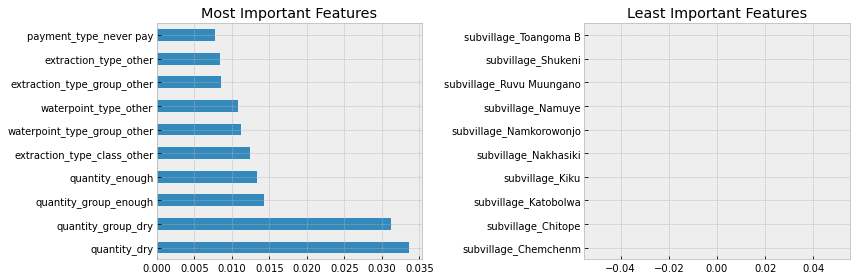

In [40]:
feat_importances = pd.Series(model_rfc1.best_estimator_.named_steps["model"].feature_importances_, index=ohe_X_train.columns)

fig, (ax1, ax2) = plt.subplots(1,2, figsize =(12,4))
feat_importances.nlargest(10).plot(kind='barh', ax=ax1)
feat_importances.nsmallest(10).plot(kind='barh', ax=ax2)
ax1.title.set_text('Most Important Features')
ax2.title.set_text('Least Important Features')
fig.tight_layout();

In [ ]:
# cross validation of model
from sklearn.model_selection import cross_val_score
print('Mean Random Forest Classifier Cross-Val Score (k=3):')
print(cross_val_score(model_rfc1, ohe_X_train, y_train, cv=3).mean())

In [54]:
# create predictions on train set
preds = model_rfc1.predict(ohe_X_test)

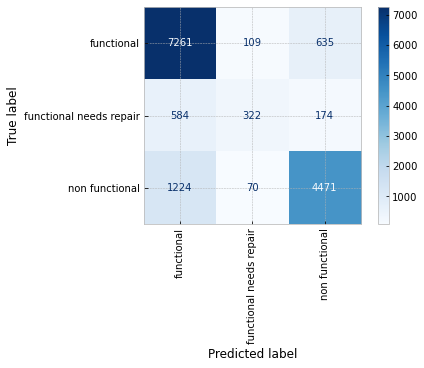

In [53]:
# plot the confusion matrix
plot_confusion_matrix(model_rfc1, ohe_X_test, y_test,
                     cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.show()

> **Observations**: We see 635 examples of false negatives (true: functional, predicted: non-functional) and 1224 examples of false positives (true: non-functional, predicted: functional). It would be more pertinent to address the false positives, as these water pumps are crucially in need of repair. To a lesser degree, visiting false negative pumps might just cost an inspector a visit and some time, as the pump is indeed functional. <br><br> In light of this, the model itself can be further optimized as there almost double the number of false positives as false negatives.

In [57]:
print(classification_report(y_test, preds))

                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      8005
functional needs repair       0.64      0.30      0.41      1080
         non functional       0.85      0.78      0.81      5765

               accuracy                           0.81     14850
              macro avg       0.76      0.66      0.69     14850
           weighted avg       0.81      0.81      0.80     14850



In [ ]:
# # check the AUC for predictions
# # y_score = model_rfc1.decision_function(ohe_X_test)
# false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, preds) #y_score
# roc_auc = auc(false_positive_rate, true_positive_rate)
# print('\nAUC is :{0}'.format(round(roc_auc, 2)))

# # plot the ROC curve
# sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# plt.figure(figsize=(10, 8))
# lw = 2
# plt.plot(false_positive_rate, true_positive_rate, color='darkorange',
#          lw=lw, label='ROC curve')
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.yticks([i/20.0 for i in range(21)])
# plt.xticks([i/20.0 for i in range(21)])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.show()

# Other models

### Logistic Regression with hyperparameter tuning

In [ ]:
log_model = LogisticRegression(random_state=73)
log_grid = [{'model__C': [np.logspace(-4, 4, 1)], 
         'model__penalty': ['l1', 'l2']}]

model_log = model_train(ohe_X_train, y_train, log_model, log_grid, ohe_X_test, y_test, test_model=False)

### Logistic Regression with Principal Component Analysis (dimensionality reduction)

In [ ]:
# determine the number of principal components to explain 95% of the variance
pca = PCA()
pca.fit_transform(ohe_X_train)

# determine the number of features to capture 95% of the variance
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95 = ohe_X_train.shape[1] - n_over_95 + 1
print("Number features: {}\tTotal Variance Explained: {}".format(n_to_reach_95, total_explained_variance[n_to_reach_95-1]))

# subset the dataset to these principal components which capture 95% of the overall variance
# reproject the dataset into a lower-dimensional space using PCA
pca = PCA(n_components=n_to_reach_95)
X_pca_train = pca.fit_transform(ohe_X_train)
X_pca_test = pca.transform(ohe_X_test)

pca.explained_variance_ratio_.cumsum()[-1]
# #### refit a model on the compressed dataset ####
# clf = svm.SVC(gamma='auto')
# train_pca_acc = clf.score(X_pca_train, y_train)
# test_pca_acc = clf.score(X_pca_test, y_test)
# print('Training Accuracy: {}\tTesting Accuracy: {}'.format(train_pca_acc, test_pca_acc))

In [ ]:
# create a function to train a model with PCA
def model_train_pca(model, grid):
    '''
    Function to train a model with PCA using a grid and pipeline
    
    Args:
        model (classifier): type of algorithm to train
        grid (list): list contains dictionary of model hyperparameters

    Returns:
        model (prints accuracy) 
    '''
    # construct a pipeline
    pipe = Pipeline([('pca', PCA(n_components=403, random_state=73)),
                    ('model', model)])

    # Define a grid search
    gridsearch = GridSearchCV(estimator=pipe, 
                          param_grid=grid, 
                          scoring='accuracy', 
                          cv=3)

    # Fit the pipelines
    gridsearch.fit(X_pca_train, y_train)

    best_parameters = gridsearch.best_params_

    print("Grid Search found the following optimal parameters: ")
    for param_name in sorted(best_parameters.keys()):
        print("%s: %r" % (param_name, best_parameters[param_name]))

    # Print the accuracy on test set
    print(f'pipeline test accuracy:{gridsearch.score(X_pca_test, y_test) :.2%}')
    
    return gridsearch

model = LogisticRegression(random_state=73)
grid = [{'model__C': np.logspace(-4, 4, 50), 
         'model__penalty': ['l1', 'l2']}]

model_pca = model_train_pca(model, grid)

### K-Neighbors with hyperparameter tuning

In [ ]:
knn_model = KNeighborsClassifier()
# grid = [{'model__n_neighbors': [11, 19],
#          'model__weights': ['uniform', 'distance'],
#          'model__metric': ['euclidean', 'manhattan']}]
knn_grid = [{'model__n_neighbors': [5,11],
         'model__weights': ['uniform'],
         'model__metric': ['minkowski']}]

model_knn = model_train(ohe_X_train, y_train, knn_model, knn_grid, ohe_X_test, y_test, test_model=False)

### SVM with hyperparameter tuning

In [ ]:
svm_model = SVC(random_state=73)
# grid = [{'model__C' : np.linspace(.1, 10, num=2),
#         'model__gamma' : np.linspace(10**-3, 5, num=2),
#         'model__kernel': ['linear','rbf', 'poly', 'sigmoid']}]
svm_grid = [{'model__C' : [1],
        'model__gamma' : ['scale'],
        'model__kernel': ['rbf']}]

model_svm = model_train(ohe_X_train, y_train, svm_model, svm_grid, ohe_X_test, y_test, test_model=False)

### DecisionTree with hyperparameter tuning

In [ ]:
decisiontree_model = DecisionTreeClassifier(random_state=73)
decisiontree_grid = [{'model__criterion': ['gini', 'entropy'],
         'model__max_depth': [None, 2, 3, 4, 5, 6],
         'model__min_samples_split': [2, 5, 10],
         'model__min_samples_leaf': [1, 2, 3, 4, 5, 6]}]

model_decisiontree = model_train(ohe_X_train, y_train, decisiontree_model, decisiontree_grid, ohe_X_test, y_test, test_model=False)

### AdaBoost with hyperparameter tuning

In [ ]:
adaboost_model = AdaBoostClassifier(random_state=73)
adaboost_grid = [{'model__n_estimators': [30, 50, 70],
         'model__learning_rate': [1.0, 0.5, 0.1]}]

model_adaboost = model_train(ohe_X_train, y_train, adaboost_model, adaboost_grid, ohe_X_test, y_test, test_model=False)

### XGBoost with hyperparameter tuning

In [ ]:
xgboost_model = xgb.XGBClassifier(random_state=73)
xgboost_grid = [{'model__learning_rate': [0.05, 0.1],
         'model__max_depth': [3, 6],
         'model__min_child_weight': [5, 10],
         'model__subsample': [0.3, 0.7],
         'model__n_estimators': [5, 30, 100, 250]}]

model_xgboost = model_train(ohe_X_train, y_train, xgboost_model, xgboost_grid, ohe_X_test, y_test, test_model=False)

### GradientBoosting with hyperparameter tuning

In [ ]:
gradientboosting_model = GradientBoostingClassifier(random_state=73)
gradientboosting_grid = [{'model__loss':["deviance"],
         'model__learning_rate': [0.01, 0.2],
         'model__min_samples_split': [0.1, 0.5],
         'model__min_samples_leaf': [0.1, 0.5],
         'model__max_depth':[3, 8],
         'model__max_features':["log2","sqrt"],
         'model__criterion': ["friedman_mse",  "mae"],
         'model__subsample':[0.5, 1.0],
         'model__n_estimators':[10]}]

model_gradientboosting = model_train(ohe_X_train, y_train, gradientboosting_model, gradientboosting_grid, ohe_X_test, y_test, test_model=False)

## Evaluation

### Final Model

After training various models and tuning hyperparameters, we see that the `RandomForest` classifier achieved the highest accuracy with a pipeline test accuracy of `81.17%`.

### Making Predictions

In [34]:
# import test data to be used for testing
test_df = pd.read_csv('testing_values.csv')

# remove labels from selected_features variable 
test_selected_features = selected_features.remove('status_group')

In [35]:
# preprocess the test data
testing_data, labels2 = data_preparation(test_df, selected_features, test_data=True)

In [36]:
# OneHotEncode the test data
ohe_X_training, ohe_X_testing = one_hot_encode(features, testing_data)

In [37]:
# retrain the final model on complete data set (training & validation)
final_model = model_train(ohe_X_training, labels, rfc_model1, rfc_grid1, test_model=True)

In [38]:
# predict the status group on the test data and export the list
results = final_model.predict(ohe_X_testing)

# export results
export_results = ohe_X_testing.index.copy()
results_dataframe = pd.DataFrame(export_results)
results_dataframe['status_group'] = results

results_dataframe.to_csv('results.csv', index=False)

Score results on drivendata.org:
<img src="drivendatascore.png">